<div style="border: 2px solid #4CAF50; background-color: #f0f9f0; padding: 10px; border-radius: 8px; text-align: center;">
  <h2 style="color: #4CAF50; margin: 0;"> Author Prediction, Applying Long-Term Short-Term Recurrent Neural Network
 </h2>
</div>


 ## Data Justification ##

<div >In this analysis for author prediction, we applied a combination of tools to enhance the prediction workflow and improve every step of this work. First, let's highlight that the code used SpySparks and TensorFlow, both of which were used with different tasks. SpySparks was applied for large-scale data processing, data handling, and feature engineering, while TensorFlow was used to train and evaluate the model.</div>

## Dataset ##

<div > The dataset from Kaggle contains 93,600 texts from 50 authors, provided in the Fifty Victorian Era Novelists Authorship Attribution Data (2018) collection. The dataset is suitable for a Long Short-Term Memory (LSTM) Recurrent Neural Network because the text is sequential in nature, captures unique patterns for each author, and enables accurate prediction. It consists of two files: the first is the training dataset, which contains two columns (text and author) and was used to train and evaluate the model; the second contains only one column (text) and was used for author prediction.</div >

## Analysis Plan ##


  1.	Dataset Evaluation and Justification
    
  2.	Exploratory Data Analysis (EDA)

  3.	Feature Selection

  4.    Model Evaluation

  5.	Model Training Plan

  6.	Model Evaluation Plan

  7.    Prediction (Second dataset)

### Data Preprocessing (PySpark First dataset) ###


In [138]:
pip show pyspark #check the pyspark details

Name: pyspark
Version: 4.0.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /opt/anaconda3/envs/tf_env3/lib/python3.10/site-packages
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession #starting spark session and Spark version

spark = SparkSession.builder \
    .appName("AuthorPrediction") \
    .getOrCreate()

print("Spark session started:", spark.version)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/03 05:07:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/03 05:07:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark session started: 4.0.1


In [3]:
spark.sparkContext.setLogLevel("ERROR")# very Spark application generates logs (INFO, WARN, ERROR, DEBUG).


In [4]:
pip install charset_normalizer# instaling chart_normalizer

Note: you may need to restart the kernel to use updated packages.


## Importing Libraries ##

In [5]:
import numpy as np #for numerical operations
import pandas as pd # for data manipulation 
import tensorflow as tf #for import tensorflow open-source machine learning, suitable for training neural networks. 
from sklearn.preprocessing import LabelEncoder # to convert categorical labels into numerical labels.
from tensorflow.keras.preprocessing.text import Tokenizer# it's part of keras and it was used for turning text into a sequential integer.
from sklearn.model_selection import train_test_split## Splits dataset into training and test sets
import re#Regular expressions for text cleaning 
from tensorflow.keras.preprocessing.text import Tokenizer# Pads sequences to the same length (important for LSTMs)

from tensorflow.keras.preprocessing.sequence import pad_sequences#Used to build models layer by layer
from tensorflow.keras.models import Sequential#
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout## LSTM: Long Short-Term Memory layer for sequence modeling
# Dense: Fully connected output layer
# Embedding: Turns words into dense vectors
# Dropout: Prevents overfitting by randomly ignoring neurons
from tensorflow.keras.utils import to_categorical## Converts labels into one-hot encoded format

from tensorflow.keras.callbacks import EarlyStopping# Stops training early if validation performance stops improving

from pyspark.sql.functions import lower, regexp_replace, trim# PySpark functions for text preprocessing: lowercase, remove patterns, trim spaces

from tensorflow.keras.layers import BatchNormalization# Normalizes activations, improves stability during training
from tensorflow.keras.layers import Bidirectional, LSTM# Bidirectional wrapper for LSTMs (looks at text both forward and backward)





/opt/anaconda3/envs/tf_env3/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [6]:
import os# checking spark version, once more

os.environ["PYSPARK_PYTHON"] = "/opt/anaconda3/envs/tf_env3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/anaconda3/envs/tf_env3/bin/python"

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("AuthorPrep").getOrCreate()
print("Spark version:", spark.version)


Spark version: 4.0.1


In [7]:
df_spark = spark.read.csv("Gungor_2018_VictorianAuthorAttribution_data-train.csv", header=True, encoding='ISO-8859-1')#Loading datase and first fiverows
df_spark.printSchema()
df_spark.show(5)


root
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+--------------------+------+
|                text|author|
+--------------------+------+
|ou have time to l...|     1|
|wish for solitude...|     1|
|and the skirt ble...|     1|
|of san and the ro...|     1|
|an hour s walk wa...|     1|
+--------------------+------+
only showing top 5 rows


In [8]:
from pyspark.sql.functions import length# remove values and filters shorter than 50 characters 

df_clean = df_spark.filter(df_spark["text"].isNotNull()) \
                   .filter(length(df_spark["text"]) > 50)


In [9]:
df_clean.count(), df_clean.dropDuplicates().count()#checking duplicates values


(53678, 53678)

In [10]:
df_clean.describe().show()#the statistics about the texts


[Stage 11:>                                                         (0 + 8) / 8]

+-------+--------------------+------------------+
|summary|                text|            author|
+-------+--------------------+------------------+
|  count|               53678|             53678|
|   mean|                NULL|24.969466075487166|
| stddev|                NULL|13.870535982665045|
|    min|a a b dr j c g b ...|                 1|
|    max|â â â â â â â â â...|                 9|
+-------+--------------------+------------------+



In [11]:
df_clean.printSchema()#Display the struteru of the dataset



root
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



In [12]:
from pyspark.sql.functions import col, when, count# Check before processing if need to handle missing value

df_clean.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_clean.columns
]).show()


[Stage 14:=======>                                                  (1 + 7) / 8]

+----+------+
|text|author|
+----+------+
|   0|     0|
+----+------+



In [13]:
from pyspark.sql.functions import col, when, count, trim# Another robust way to handle missing values 

df_clean.select([
    count(when(col(c).isNull() | (trim(col(c)) == ""), c)).alias(c)
    for c in df_clean.columns
]).show()


[Stage 17:===========================================>              (6 + 2) / 8]

+----+------+
|text|author|
+----+------+
|   0|     0|
+----+------+



In [14]:
df_pd = df_clean.toPandas()#text processing, remove pontuation.


In [15]:
from pyspark.sql.functions import lower, regexp_replace, trim# create a new column, clean text on the sparks 

df_clean = df_spark.withColumn("clean_text",
    trim(regexp_replace(
        regexp_replace(lower(df_spark["text"]), r"[^\w\s]", ""), r"\d+", ""
    ))
)


In [16]:
df_clean.select("author", "clean_text").show(5, truncate=False)# tha five first cleaned text


[Stage 21:>                                                         (0 + 1) / 1]

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
from pyspark.sql.functions import lower, regexp_replace, trim

df_clean = df_spark.withColumn("clean_text",
    trim(regexp_replace(
        regexp_replace(lower(df_spark["text"]), r"[^\w\s]", ""), r"\d+", ""
    ))
)


In [18]:
df_pd = df_clean.select("clean_text", "author").toPandas() #Converting the new cleaned dataset into panda
texts = df_pd["clean_text"].astype(str).tolist()
labels = df_pd["author"].astype(str).tolist()


In [19]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # ← This creates the missing y
num_classes = len(label_encoder.classes_)


In [28]:
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)


## Split the data ##

Splitting the data into training sets and validation sets is essential to train the data

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Train Model ##

In this step, is start to build a  Bidirectional LSTM neural network for multi-class text. It captures long-range dependencies in text using LSTM. Bidirectional layers allow the model to understand context from both directions. Dropout and batch normalization help prevent overfitting, which is common in text classification.

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, BatchNormalization

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    BatchNormalization(),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


From tensorflow.keras.callbacks import EarlyStopping, prevent overfitting by stopping epochs training when it achieves the best validation accuracy,save time and computer resources. 


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',       #  monitor 'val_accuracy'
    patience=3,               #
    restore_best_weights=True
)


Ensures the loss function penalizes misclassification of minority classes more, improving balanced accuracy.

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train is integer-encoded
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))


In [33]:
print("y_train shape:", y_train.shape)#Checking the number of y-train and y-valalidation.
print("y_val shape:", y_val.shape)


y_train shape: (42942,)
y_val shape: (10736,)


Model-compile:Compile the LSTM model and let it be ready to be trained

In [35]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)


The model will be trained for up to 10 epochs. The main objective is to observe how the model’s performance evolves across epochs. All hyperparameters, including early stopping and class weights, are already set to ensure the model trains effectively without risking overfitting.
Early stops monitor validation loss and stop training if no improvement is observed for a few consecutive epochs, restoring the best model weights. Class weights ensure that authors with fewer samples are not ignored, allowing the model to learn balanced representations for all classes. This setup ensures the model trains efficiently and avoids overfitting. The model achieves  0.45, which is significant for  50-author prediction.

In [43]:
  history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/10
336/336 - 400s - 1s/step - accuracy: 0.3799 - loss: 2.1831 - val_accuracy: 0.3680 - val_loss: 2.2747
Epoch 2/10
336/336 - 360s - 1s/step - accuracy: 0.3880 - loss: 2.1405 - val_accuracy: 0.3709 - val_loss: 2.3136
Epoch 3/10
336/336 - 364s - 1s/step - accuracy: 0.4055 - loss: 2.0705 - val_accuracy: 0.3708 - val_loss: 2.3090
Epoch 4/10
336/336 - 364s - 1s/step - accuracy: 0.4175 - loss: 2.0205 - val_accuracy: 0.3905 - val_loss: 2.2170
Epoch 5/10
336/336 - 386s - 1s/step - accuracy: 0.4313 - loss: 1.9697 - val_accuracy: 0.4019 - val_loss: 2.2203
Epoch 6/10
336/336 - 396s - 1s/step - accuracy: 0.4443 - loss: 1.9279 - val_accuracy: 0.4147 - val_loss: 2.1415
Epoch 7/10
336/336 - 407s - 1s/step - accuracy: 0.4626 - loss: 1.8689 - val_accuracy: 0.4300 - val_loss: 2.1589
Epoch 8/10
336/336 - 439s - 1s/step - accuracy: 0.4743 - loss: 1.8237 - val_accuracy: 0.4346 - val_loss: 2.1568
Epoch 9/10
336/336 - 458s - 1s/step - accuracy: 0.4853 - loss: 1.7721 - val_accuracy: 0.4389 - val_loss:

In [44]:
model.save("author_model_final.keras")# saving the model


In [45]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


## Plot ##

The training history to learning curve: 
- Left subplot. Model Accuracy Curve – shows how training and validation accuracy change over epochs.
- Right subplot: Model Loss Curve – shows how training and validation loss change over epochs.
So together, they are referred to as learning curves, which are commonly used to visualize model performance and check for overfitting or underfitting.

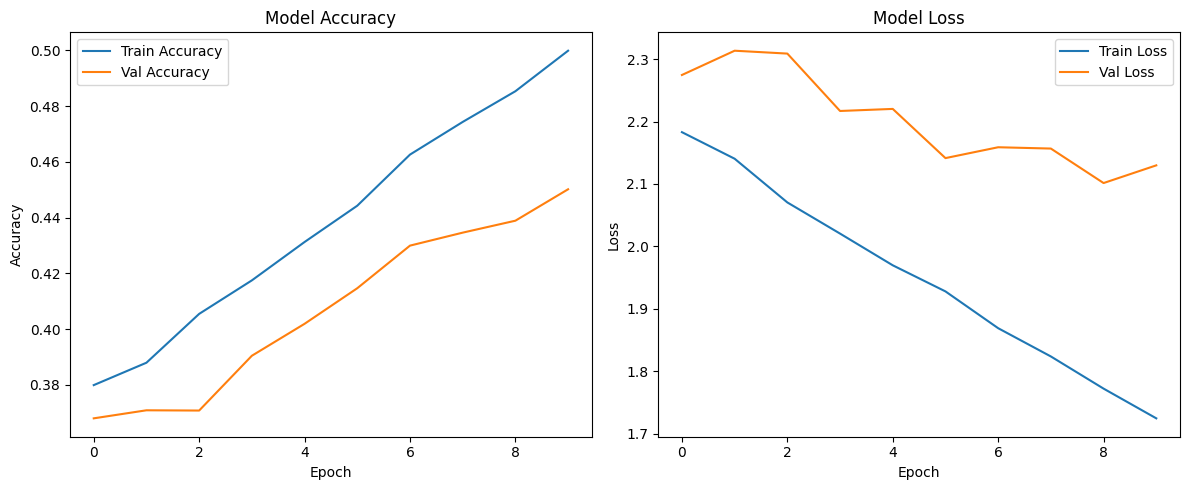

In [46]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model ##

Here is the step to evaluate the trained model on the validation set and print the results:

  -Provides a quantitative measure of how well your model performs on unseen data. 
  
  -Combined with learning curves, it helps you assess overfitting or underfitting.

In [52]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Validation Accuracy: 0.4389
Validation Loss: 2.1015


## Confusion Matrix ##

This code creates a normalized confusion matrix heatmap for your validation predictions, which is very useful for evaluating multi-class classification performance.

Helps identify which authors are commonly confused by the model.

Normalization allows you to compare performance across authors fairly.

Visualizes model strengths and weaknesses in a multi-class setting.

336/336 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step


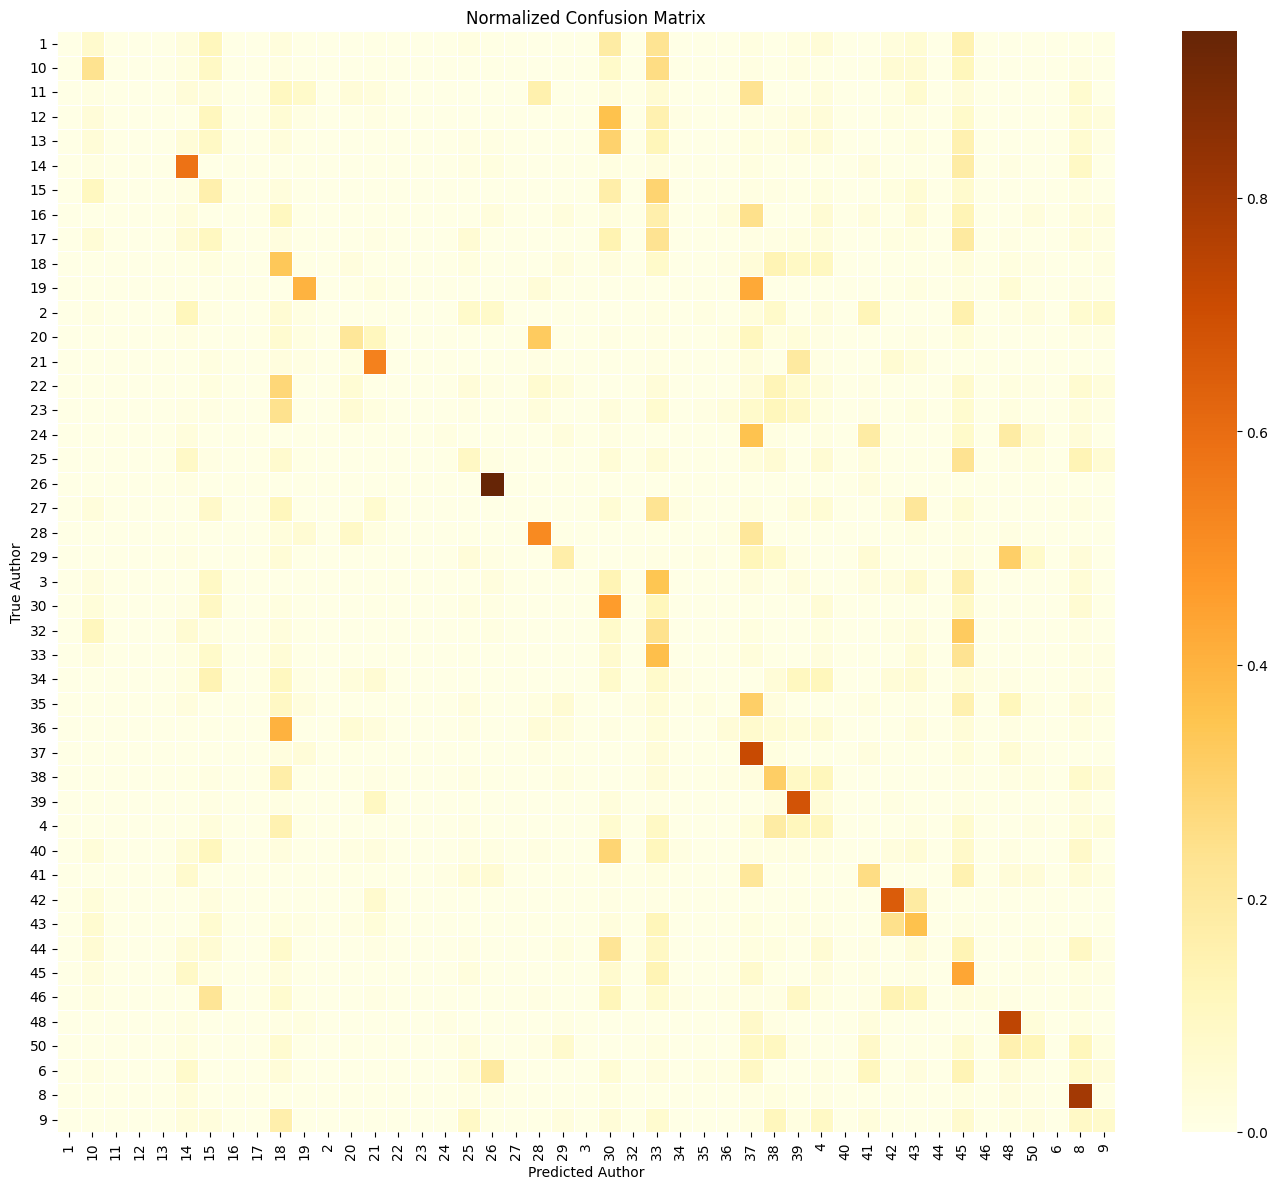

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Normalize by row (true author)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, cmap='YlOrBr', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, annot=False, fmt='.2f',
            linewidths=0.5, linecolor='white')

plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Prediction(Second Dataset) ##

In this second part of the analysis, the focus is on predicting the author's name and code. Two datasets were used because the first dataset is labelled, but it is not fully suitable for author prediction. However, the same file also contains a text-only dataset, which is perfect for this task.

In [104]:
df = spark.read.csv("Gungor_2018_VictorianteText_data.csv", header=True, inferSchema=True)#loading the data, and the 5 first rows.
texts = df_clean.select("text").toPandas()["text"].tolist()

df.show(5)



+--------------------+
|                text|
+--------------------+
|nt it seems te me...|
|to talk about why...|
|my foot on the gr...|
|hour or wait for ...|
|will not listen t...|
+--------------------+
only showing top 5 rows


In [105]:
max_seq_len = 200 #maximum sequence length for your text sequences before feeding them into the LSTM


In [106]:
equences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_seq_len)


In [107]:
pred_probs = model.predict(padded)
pred_classes = np.argmax(pred_probs, axis=1)
decoded_authors = label_encoder.inverse_transform(pred_classes)


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 97s 80ms/step


From  https://dataworks.indianapolis.iu.edu/handle/11243/23, I got the list of the 50 authors for better performance on the prediction. They are listed correctly, like in the  Raw data.


In [112]:
results_df = pd.DataFrame({
    "text": list(texts),
    "predicted_author": list(decoded_authors)
})


In [113]:
id_to_author = {
    0: "Ada Cambridge",
    1: "Amelia B. Edwards",
    2: "Anthony Trollope",
    3: "Arthur Conan Doyle",
    4: "Benjamin Disraeli",
    5: "Bram Stoker",
    6: "Charles Dickens",
    7: "Charles Kingsley",
    8: "Charlotte Brontë",
    9: "Dinah Craik",
    10: "Edward Bulwer-Lytton",
    11: "Elizabeth Gaskell",
    12: "Ellen Wood",
    13: "Emma Jane Worboise",
    14: "Florence Marryat",
    15: "Frances Hodgson Burnett",
    16: "George Eliot",
    17: "George Gissing",
    18: "George MacDonald",
    19: "George Meredith",
    20: "Grant Allen",
    21: "Hall Caine",
    22: "H. Rider Haggard",
    23: "Henry James",
    24: "Henry Kingsley",
    25: "James Payn",
    26: "Jerome K. Jerome",
    27: "John Galsworthy",
    28: "John Morley",
    29: "Joseph Conrad",
    30: "Margaret Oliphant",
    31: "Marie Corelli",
    32: "Mary Elizabeth Braddon",
    33: "Mrs. Humphry Ward",
    34: "Ouida",
    35: "Rhoda Broughton",
    36: "Richard Doddridge Blackmore",
    37: "Robert Louis Stevenson",
    38: "Samuel Butler",
    39: "Thomas Hardy",
    40: "Thomas Hughes",
    41: "Thomas Love Peacock",
    42: "Walter Besant",
    43: "Wilkie Collins",
    44: "William Black",
    45: "William Dean Howells",
    46: "William Makepeace Thackeray",
    47: "William Morris",
    48: "William Wilkie Collins",
    49: "W. Somerset Maugham"
}


This is the main step of the analysis. Using the author list, it is possible to verify whether the prediction is correct by checking if the predicted ID number matches the corresponding author from the list.

In [114]:
id = 2
author = id_to_author[id]
print(author)  


Anthony Trollope


In [111]:
print(len(texts))            # Total number of texts
print(len(decoded_authors))  # Number of predictions


38809
38809


Another approach for prediction is to directly compare the predicted ID with the author list to determine the author name.

In [125]:
for i in range(5):
    print(f"Text: {texts[i][:100]}...")
    print(f"Predicted Author: {decoded_authors[i]}\n")


Text: nt it seems te me how much money is he worth and that within a reasonable margin i can tell you as f...
Predicted Author: 10

Text: to talk about why you heard of such a case as his in your life tell me all about it said mrs her cha...
Predicted Author: 39

Text: my foot on the ground and said i believe you did that on purpose you re quite right he replied i bro...
Predicted Author: 38

Text: hour or wait for miss oh wait for by all means said miss she can t be much later then she resumed to...
Predicted Author: 43

Text: will not listen to such words now go and remember he drove away and she went back he house no he cou...
Predicted Author: 45



This line of code counts the frequency of predicted authors and shows the top 10 most predicted authors

In [126]:
import pandas as pd

results_df = pd.DataFrame({
    "text": texts,
    "predicted_author": decoded_authors
})
results_df.to_csv("second_dataset_predictions.csv", index=False)


In [127]:
pd.Series(decoded_authors).value_counts().head(10)


37    5457
8     3959
45    3106
33    2885
18    2395
39    2190
48    1997
26    1950
30    1818
14    1537
Name: count, dtype: int64

The bar chart titled “Top 10 Text Dataset” highlights the distribution of predicates across the most represented authors in the dataset. Author 31 leads with over 5,000 predicates, followed by Authors 50 and 49 with around 4,000 each. The remaining authors range between 2,000 and 3,000 predicates. This visualization confirms that the dataset is skewed toward a few dominant authors, which has direct implications for model training. It justifies the need for class balancing techniques to prevent bias and ensure fair generalization across all 50 classes. By identifying these disparities early in the analysis, we were able to plan corrective steps such as stratified sampling and weighted loss functions to improve model fairness and performance.

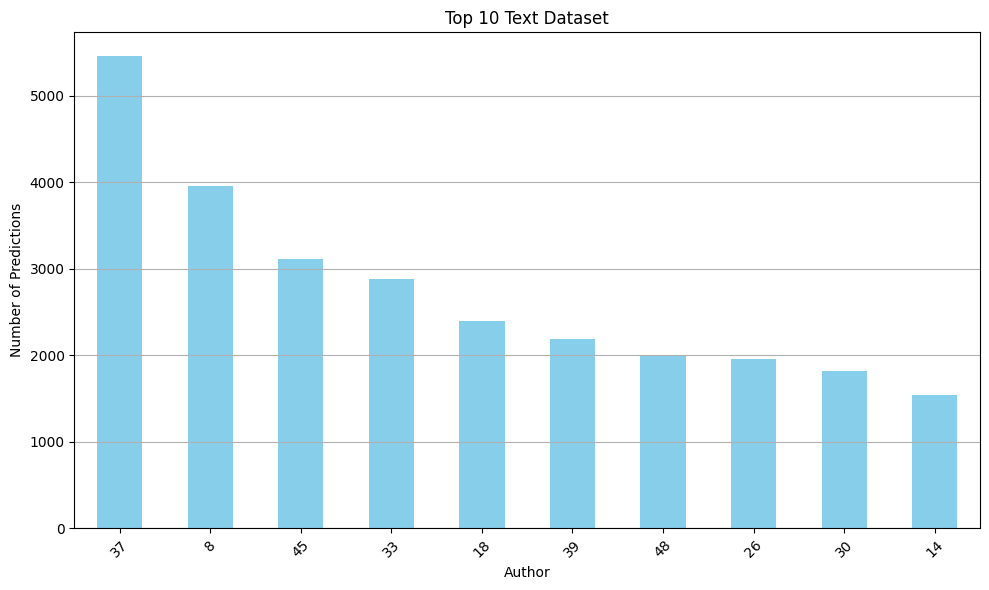

In [130]:
import matplotlib.pyplot as plt
import pandas as pd


author_counts = pd.Series(decoded_authors).value_counts().head(10)

plt.figure(figsize=(10, 6))
author_counts.plot(kind='bar', color='skyblue')
plt.title("Top 10 Text Dataset")
plt.xlabel("Author")
plt.ylabel("Number of Predictions")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [131]:
import pandas as pd

results_df = pd.DataFrame({
    "text": texts,  #  second dataset texts
    "predicted_author": decoded_authors  # model predictions
})


In [133]:
model.save("author_model_v1.keras")#saving the model


import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
